# 3DVSS 2025 - Deep Learning (CNNs)

In [ ]:
!pip install -q torch torchvision

## Intro to CNN

Classification of handwritten digits (MNIST Dataset) using a simple CNN

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


import torchvision
from torchvision.datasets import CIFAR10
from torch.utils.data import random_split
from torch.utils.data import DataLoader

import torchvision.transforms as transforms


import matplotlib.pyplot as plt
import numpy as np
import cv2

from tqdm import tqdm

In [ ]:
# MNIST images are grayscale, so only one channel
# Normalize with mean=0.5 and std=0.5 to get values in [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(trainset, batch_size=64, shuffle=True)
val_loader = DataLoader(testset, batch_size=64, shuffle=False)

classes = [str(i) for i in range(10)]  # Digits 0 to 9


In [ ]:
# Visualising Dataset

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(f"Number of training samples: {len(trainset)}")
print(f"Number of test samples: {len(testset)}")
print(f"Shape of one image tensor: {images[0].shape}")  # Should be [1, 28, 28]
print(f"Data type of image tensor: {type(images[0])}")
print(f"Pixel value range: min={images.min().item():.2f}, max={images.max().item():.2f}")


Number of training samples: 60000
Number of test samples: 10000
Shape of one image tensor: torch.Size([1, 28, 28])
Data type of image tensor: <class 'torch.Tensor'>
Pixel value range: min=-1.00, max=1.00


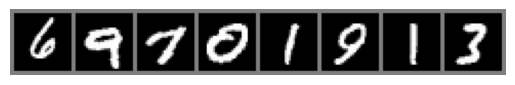

6 9 7 0 1 9 1 3


In [ ]:
# Visualising images

# Helper function to unnormalize and show images
def imshow(img):
    img = img * 0.5 + 0.5  # unnormalize from [-1, 1] to [0, 1]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)).squeeze(), cmap='gray')
    plt.axis('off')
    plt.show()

# Show a batch of images with labels
imshow(torchvision.utils.make_grid(images[:8], nrow=8))
print(' '.join(f'{labels[j].item()}' for j in range(8)))


In [ ]:
# Simple CNN class
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 7 * 7, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [1,28,28] -> [4,14,14]
        x = self.pool(F.relu(self.conv2(x)))  # [4,14,14] -> [8,7,7]
        x = x.view(-1, 8 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def inspect_forward_shapes(model, input_tensor):
    x = input_tensor
    print(f"Input: {x.shape}")

    x = model.conv1(x)
    print(f"After conv1: {x.shape}")
    x = F.relu(x)
    x = model.pool(x)
    print(f"After pool1: {x.shape}")

    x = model.conv2(x)
    print(f"After conv2: {x.shape}")
    x = F.relu(x)
    x = model.pool(x)
    print(f"After pool2: {x.shape}")

    x = x.view(-1, 8 * 7 * 7)
    print(f"After flattening: {x.shape}")

    x = model.fc1(x)
    print(f"After fc1: {x.shape}")
    x = F.relu(x)

    x = model.fc2(x)
    print(f"After fc2 (final output): {x.shape}")

dummy_input = torch.randn(1, 1, 28, 28).to(device)
inspect_forward_shapes(model, dummy_input)


Input: torch.Size([1, 1, 28, 28])
After conv1: torch.Size([1, 4, 28, 28])
After pool1: torch.Size([1, 4, 14, 14])
After conv2: torch.Size([1, 8, 14, 14])
After pool2: torch.Size([1, 8, 7, 7])
After flattening: torch.Size([1, 392])
After fc1: torch.Size([1, 32])
After fc2 (final output): torch.Size([1, 10])


In [ ]:
# Training the model

def train(model, loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        loop = tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}")
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        print(f"Epoch {epoch+1} completed. Avg Loss: {running_loss/len(loader):.4f}")


train(model, train_loader, criterion, optimizer, epochs=5)



Epoch 1/5: 100%|██████████| 938/938 [00:41<00:00, 22.59it/s, loss=0.195]


Epoch 1 completed. Avg Loss: 0.3776


Epoch 2/5: 100%|██████████| 938/938 [00:31<00:00, 29.68it/s, loss=0.0987]


Epoch 2 completed. Avg Loss: 0.1124


Epoch 3/5: 100%|██████████| 938/938 [00:32<00:00, 29.11it/s, loss=0.0386]


Epoch 3 completed. Avg Loss: 0.0849


Epoch 4/5: 100%|██████████| 938/938 [00:31<00:00, 29.90it/s, loss=0.101]


Epoch 4 completed. Avg Loss: 0.0716


Epoch 5/5: 100%|██████████| 938/938 [00:31<00:00, 29.87it/s, loss=0.124]

Epoch 5 completed. Avg Loss: 0.0608


In [ ]:
# Evaluation

def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy on test set: {accuracy:.2f}%')
    return accuracy

evaluate(model, val_loader)


Accuracy on test set: 98.18%


98.18

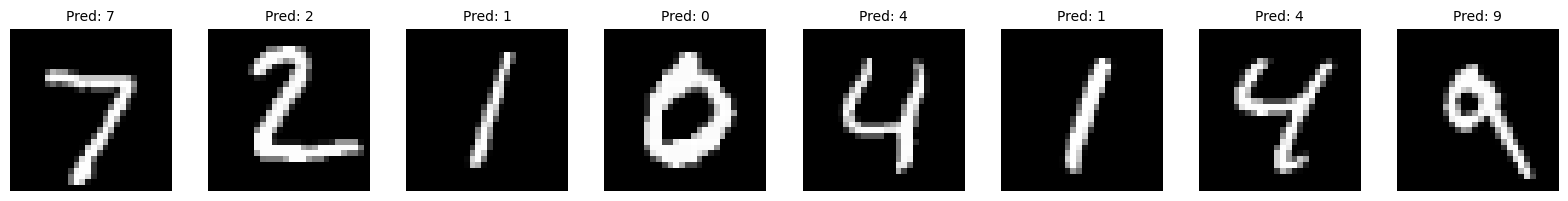

In [ ]:
# Display predictions on test samples

def visualize_predictions(model, loader, num_images=8):
    model.eval()
    images, labels = next(iter(loader))
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    # Use matplotlib subplots
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 2))
    for i in range(num_images):
        ax = axes[i]
        img = images[i].cpu().squeeze() * 0.5 + 0.5  # Unnormalize
        ax.imshow(img, cmap='gray')
        ax.set_title(f'Pred: {predicted[i].item()}', fontsize=10)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

visualize_predictions(model, val_loader)


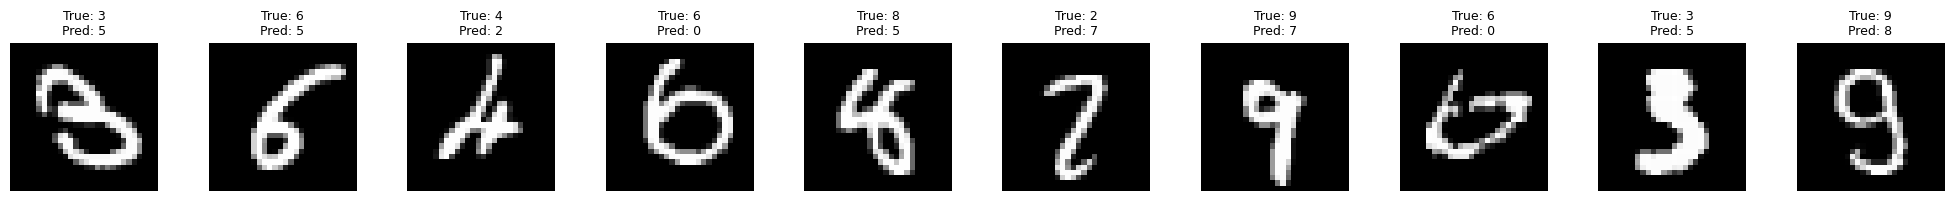

In [ ]:
# False predictions

def visualize_false_predictions(model, loader, num_images=10):
    model.eval()
    incorrect = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            # Collect incorrect predictions
            for img, pred, label in zip(images, predicted, labels):
                if pred != label:
                    incorrect.append((img.cpu(), pred.cpu(), label.cpu()))
                if len(incorrect) >= num_images:
                    break
            if len(incorrect) >= num_images:
                break

    # Plotting
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 2))
    for i in range(num_images):
        img, pred, label = incorrect[i]
        ax = axes[i]
        img = img.squeeze() * 0.5 + 0.5  # Unnormalize
        ax.imshow(img, cmap='gray')
        ax.set_title(f'True: {label}\nPred: {pred}', fontsize=9)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

visualize_false_predictions(model, val_loader, num_images=10)


Try deepening the CNN by adding more convolutional and fully connected layers. Explore whether increasing the network's capacity leads to better test accuracy. Can you design a deeper architecture that outperforms the current one?

## Fine tuning ResNet

Finetuning ResNet for classification of flowers

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision.datasets import Flowers102
from sklearn.model_selection import train_test_split
import numpy as np


In [ ]:
# Download the dataset and preprocessing

# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),      # ResNet input size
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)  # Normalize to [-1, 1]
])

dataset = Flowers102(root='./data', split='train', download=True, transform=transform)
testset = Flowers102(root='./data', split='test', download=True, transform=transform)

# Split train into train/val
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
trainset, valset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(trainset, batch_size=32, shuffle=True)
val_loader = DataLoader(valset, batch_size=32, shuffle=False)
test_loader = DataLoader(testset, batch_size=32, shuffle=False)


Number of training images: 816
Number of validation images: 204
Number of test images: 6149


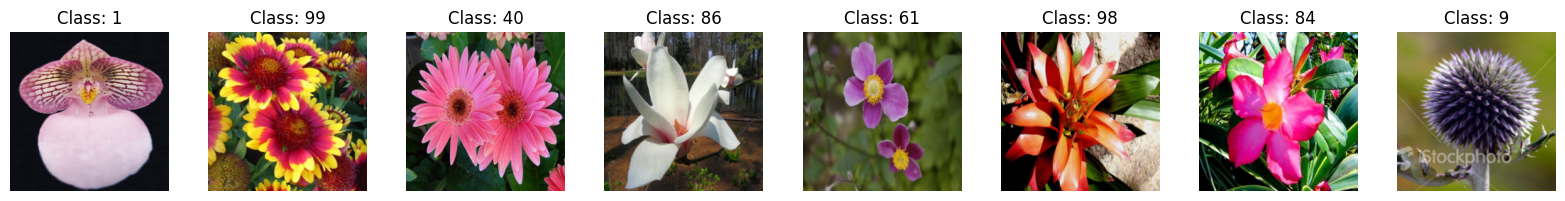

In [ ]:
# Viusalize dataset


# Print some information about the dataset
print(f"Number of training images: {len(trainset)}")
print(f"Number of validation images: {len(valset)}")
print(f"Number of test images: {len(testset)}")

# Visualize a few training samples
def show_flower_batch(dataset, num_images=8):
    loader = DataLoader(dataset, batch_size=num_images, shuffle=True)
    images, labels = next(iter(loader))

    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 2))
    for i in range(num_images):
        img = images[i].permute(1, 2, 0).numpy()
        img = img * 0.5 + 0.5  # Unnormalize from [-1,1] to [0,1]
        axes[i].imshow(img)
        axes[i].set_title(f"Class: {labels[i]}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

show_flower_batch(trainset)


In [ ]:
# Load Pretrained ResNet and Modify Final Layer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet = models.resnet18(pretrained=True)

# Freeze all layers
for param in resnet.parameters():
    param.requires_grad = False

# Replace the last FC layer for 102 flower classes
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 102)

# Only fine-tune the final layer
for param in resnet.fc.parameters():
    param.requires_grad = True

resnet = resnet.to(device)

print(resnet)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Training the model

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.fc.parameters(), lr=0.01)

def train_model(model, loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        loop = tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}")
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            loop.set_postfix(loss=loss.item())
        print(f"Epoch {epoch+1}, Loss: {running_loss / len(loader):.4f}")

train_model(resnet, train_loader, criterion, optimizer, epochs=5)


Epoch 1/5: 100%|██████████| 26/26 [01:33<00:00,  3.58s/it, loss=3.77]


Epoch 1, Loss: 6.3492


Epoch 2/5: 100%|██████████| 26/26 [01:31<00:00,  3.53s/it, loss=0.983]


Epoch 2, Loss: 1.3023


Epoch 3/5: 100%|██████████| 26/26 [01:32<00:00,  3.55s/it, loss=0.279]


Epoch 3, Loss: 0.3867


Epoch 4/5: 100%|██████████| 26/26 [01:31<00:00,  3.53s/it, loss=0.152]


Epoch 4, Loss: 0.1772


Epoch 5/5: 100%|██████████| 26/26 [01:41<00:00,  3.90s/it, loss=0.0448]

Epoch 5, Loss: 0.0949


In [ ]:
# Evaluation

def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = 100 * correct / total
    print(f"Accuracy: {acc:.2f}%")

evaluate(resnet, val_loader)

Accuracy: 76.96%


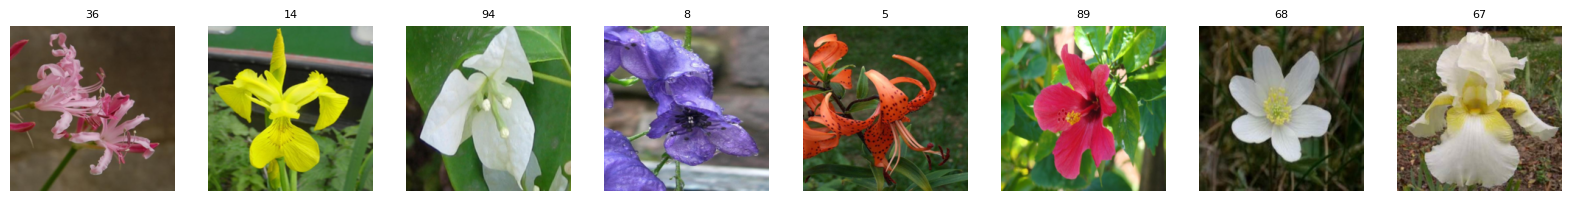

In [ ]:
# Visualization

def visualize_predictions(model, loader, num_images=8):
    model.eval()
    images, labels = next(iter(loader))
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 2))
    for i in range(num_images):
        img = images[i].cpu().permute(1, 2, 0).numpy()
        img = (img * 0.5) + 0.5  # Unnormalize
        axes[i].imshow(img)
        axes[i].set_title(f"{preds[i]}", fontsize=8)
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

visualize_predictions(resnet, val_loader)


Fine-tune VGG16 and AlexNet on the Flowers102 dataset by modifying only the final classifier layer to output 102 classes. Freeze all other layers, train for a few epochs, and compare their validation accuracy and predictions with ResNet.

## Object Detection: Faster RCNN  v/s YOLO

In [ ]:
!pip install -q ultralytics

In [ ]:
import torch
import torchvision.transforms as T
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.utils import draw_bounding_boxes
from PIL import Image
import matplotlib.pyplot as plt
import requests
from io import BytesIO

from ultralytics import YOLO


In [ ]:
# Load a sample image from the web (COCO-style image)
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
response = requests.get(url)
image_pil = Image.open(BytesIO(response.content)).convert("RGB")


In [ ]:
# Transform image for Faster R-CNN
transform = T.Compose([
    T.ToTensor()
])

image_tensor = transform(image_pil).unsqueeze(0)  # add batch dimension


In [ ]:
model_rcnn = fasterrcnn_resnet50_fpn(pretrained=True)
model_rcnn.eval()

with torch.no_grad():
    output_rcnn = model_rcnn(image_tensor)[0]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


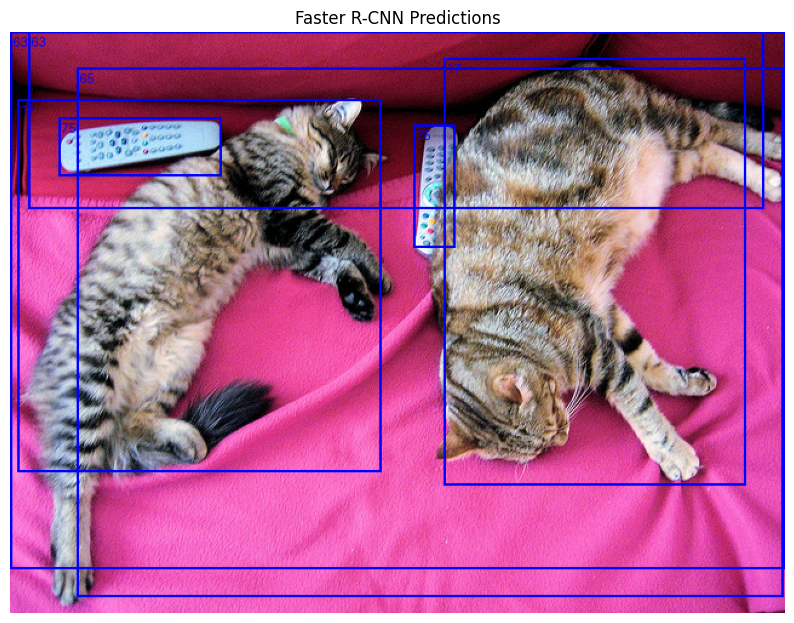

In [ ]:
# Apply confidence threshold
threshold = 0.5
boxes = output_rcnn['boxes'][output_rcnn['scores'] > threshold]
labels = output_rcnn['labels'][output_rcnn['scores'] > threshold]

# Draw boxes
image_rcnn = draw_bounding_boxes(
    (image_tensor[0] * 255).byte(), boxes,
    labels=[str(l.item()) for l in labels],
    colors="blue", width=2
)

# Show image
plt.figure(figsize=(10, 8))
plt.title("Faster R-CNN Predictions")
plt.imshow(T.ToPILImage()(image_rcnn))
plt.axis("off")
plt.show()


In [ ]:
# Load YOLOv8 pretrained model
yolo_model = YOLO('yolov8n.pt')  # you can also try 'yolov8s.pt'

# Run inference (it accepts PIL or path)
results = yolo_model(image_pil)



0: 480x640 2 cats, 1 couch, 2 remotes, 207.7ms
Speed: 36.1ms preprocess, 207.7ms inference, 5.4ms postprocess per image at shape (1, 3, 480, 640)


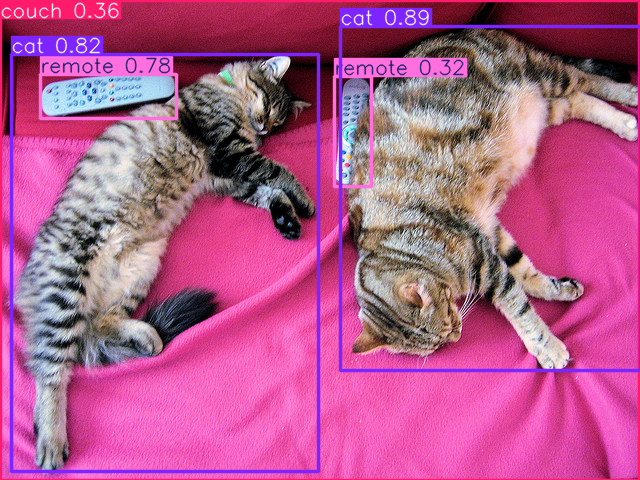

In [ ]:
# YOLOv8 has built-in visualizer
results[0].show()  # Displays image with bounding boxes (uses PIL internally)


Which model gave faster predictions and why?

Did both models detect the same objects? If not, what differences did you notice?


## Semantic Segmentation using U-Net

In [ ]:
!pip install -q segmentation-models-pytorch

In [ ]:
import torch
import torchvision.transforms as T
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import urllib.request


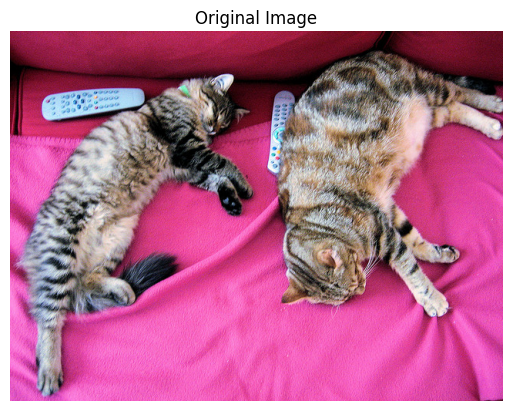

In [ ]:
# Pascal VOC-style image
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
response = requests.get(url)
image = Image.open(BytesIO(response.content)).convert("RGB")
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")
plt.show()


In [ ]:
# Define transform
preprocess = T.Compose([
    T.Resize(520),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(image).unsqueeze(0)  # [1, 3, H, W]


In [ ]:
# Load pretrained DeepLabV3 model (21 classes, Pascal VOC)
model = models.segmentation.deeplabv3_resnet50(pretrained=True)
model.eval();


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
with torch.no_grad():
    output = model(input_tensor)["out"]  # shape: [1, 21, H, W]
    predictions = torch.argmax(output.squeeze(), dim=0).cpu().numpy()  # [H, W]


In [ ]:
# Pascal VOC color palette
VOC_COLORS = np.array([
    [0, 0, 0],        # 0=background
    [128, 0, 0],      # 1=aeroplane
    [0, 128, 0],      # 2=bicycle
    [128, 128, 0],    # 3=bird
    [0, 0, 128],      # 4=boat
    [128, 0, 128],    # 5=bottle
    [0, 128, 128],    # 6=bus
    [128, 128, 128],  # 7=car
    [64, 0, 0],       # 8=cat
    [192, 0, 0],      # 9=chair
    [64, 128, 0],     # 10=cow
    [192, 128, 0],    # 11=dining table
    [64, 0, 128],     # 12=dog
    [192, 0, 128],    # 13=horse
    [64, 128, 128],   # 14=motorbike
    [192, 128, 128],  # 15=person
    [0, 64, 0],       # 16=potted plant
    [128, 64, 0],     # 17=sheep
    [0, 192, 0],      # 18=sofa
    [128, 192, 0],    # 19=train
    [0, 64, 128],     # 20=tv/monitor
])


In [ ]:
# Convert class predictions to RGB mask
def decode_segmentation(mask):
    color_mask = VOC_COLORS[mask]
    return color_mask.astype(np.uint8)

color_mask = decode_segmentation(predictions)


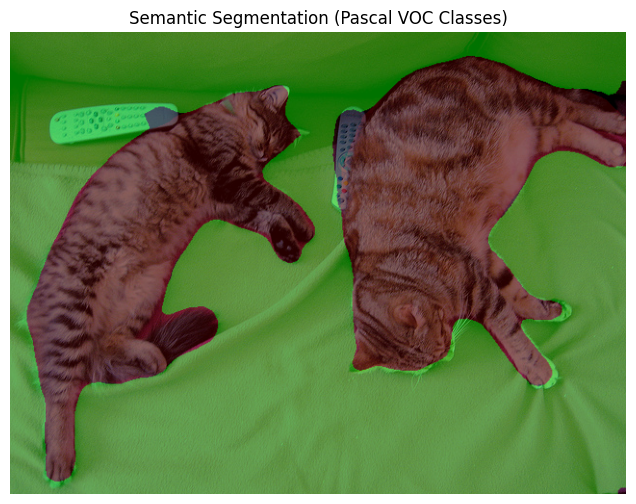

In [ ]:
# Resize mask to original image size
color_mask_resized = Image.fromarray(color_mask).resize(image.size)

# Blend original image and mask
blended = Image.blend(image, color_mask_resized, alpha=0.6)

# Show result
plt.figure(figsize=(12, 6))
plt.imshow(blended)
plt.title("Semantic Segmentation (Pascal VOC Classes)")
plt.axis("off")
plt.show()


By
[Gaurav](https://www.linkedin.com/in/gauravbehera) and [Abhinav](https://www.linkedin.com/in/abhinav-raundhal-2355192a8)